In [279]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
from scipy.constants import N_A
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [280]:
def lig_comp(t, z, ftot, x1tot, x2tot, k1, k2, koff1, koff2):

    dx1 = k1*(ftot-z[0]-z[1])*(x1tot-z[0]) - koff1*z[0]
    dx2 = k2*(ftot-z[0]-z[1])*(x2tot-z[1]) - koff2*z[1]

    dz = [dx1, dx2]

    return dz

In [281]:
Target_cell_number = 2e5
E_T_ratio = 25
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [282]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

In [283]:
#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

In [284]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e3
ftot = 2.2e5
ftot_synapse = ftot*NK_cell_IS_proportion
D_t = 1e-14
D_f = 7.4e-14
Einit = 1e-13

A0s = np.geomspace(1e-12, 1e-4, 75)

t_end = 60*60*4
t = np.geomspace(1e-10, t_end, 150)
tspan = [1e-10, t_end]

t_end1 = 60*60*4
t1 = np.geomspace(1e-10, t_end1, 100)
tspan1 = [1e-10, t_end1]

In [285]:
def calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, qoff_mod, Einit):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)/1
    k71 = (2*D_t/synapse_area)
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    Etot = Einit*sigma/E_T_ratio
    effector_cell_ops = solve_ivp(lig_comp, tspan, np.asarray([0,0], dtype='object') , method='BDF', 
                                  t_eval=t, args=np.asarray([ftot, Atot, Etot, q1, q1, qoff_mod, qoff], dtype='object'))
    A1_therapeutic = effector_cell_ops.y[0]
    A1_endogenous = effector_cell_ops.y[1]
    A1_E_stst = A1_therapeutic[-1]
    A1_endog_stst = A1_endogenous[-1]
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    A1_endog_synapse = A1_endog_stst*NK_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    ftot_bar = ftot_synapse - A1_E_pre_synapse - A1_endog_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    effector_bindings = solve_ivp(lig_comp, tspan, np.asarray([0,0], dtype='object') , method='BDF', t_eval=t, args=np.asarray([ftot_bar, A1_pre_synapse, A2_pre_synapse, k6, k7, qoff, qoff], dtype='object'))
    x1 = effector_bindings.y[0]
    x2 = effector_bindings.y[1]
    A1_synapse = x1[-1] + x2[-1]
    #A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A10_approx += (A1_pre_synapse - x1[-1])
    A20_approx += (A2_pre_synapse - x2[-1])
    sol_guess += x1[-1] + 2*x2[-1]
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    A11_approx += A1_st
    A21_approx += A2_st
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    A1_E_stst = effector_A1(A01_approx , A01_approx , Q_D_bar)
    A1_st1 = brentq(A1_steady_state, 0, sol_guess, args=((fc_crosslinks + A1_E_stst), k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [286]:
def calc_crosslinks1(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = brentq(A1_steady_state, 0, rtot, args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    ftot_bar = ftot_synapse - A1_E_pre_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A11_prop = A1_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A21_prop = A2_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A11_approx += A11_prop*A1_synapse
    A21_approx += A1_synapse*A21_prop
    A10_approx += (A1_pre_synapse - A11_approx)
    A20_approx += (A2_pre_synapse - A21_approx)
    sol_guess += A11_approx + 2*A21_approx
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    A11_approx += A1_st
    A21_approx += A2_st
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    A1_E_stst = effector_A1(A01_approx , A01_approx , Q_D_bar)
    A1_st1 = brentq(A1_steady_state, 0, sol_guess, args=((fc_crosslinks + A1_E_stst) , k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [287]:
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, ftot_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = ftot_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  2*k1*(A0)*(rt) - k1off*z[0] - k2*1*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*1*z[0]*(rt) - 2*k1off*z[1] - k5*z[1]*(rf) + k2off*z[4]
    dA01 =  k3*(A0)*(rf) - k2off*z[2] - 2*1*k6*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*1*k6*z[2]*(rt) - k1off*z[3] - 1*k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - k2off*z[4] + 1*k7*z[3]*(rt) - 2*k1off*1*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [288]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot = A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = np.asarray([A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0], dtype='object')
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = 2*(D_t +D_f)/(synapse_area)
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)/1
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF', atol=1e-5, rtol=1e-5,  t_eval=t, args=np.asarray([k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot], dtype='object'))
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return crosslinks

In [289]:
sim = np.zeros_like(A0s)
approx = np.zeros_like(A0s)
approx1 = np.zeros_like(A0s)
approx2 = np.zeros_like(A0s)
approx3 = np.zeros_like(A0s)
for j, Ainit in enumerate(A0s):
    print(j)
    #sim[j] = (calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio))/ftot_synapse
    #approx2[j] = (calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 0.5))
    approx2[j] = (calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 1, qoff, 0))
    approx[j] = (calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 1, qoff, 1e-5))
    approx3[j] = (calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 1, qoff/10, 1e-5))
    approx1[j] = (calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, 1, qoff/100, 1e-5))

0
1
2
3
4
5
6


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


Text(0, 0.5, 'Number of Crosslinks')

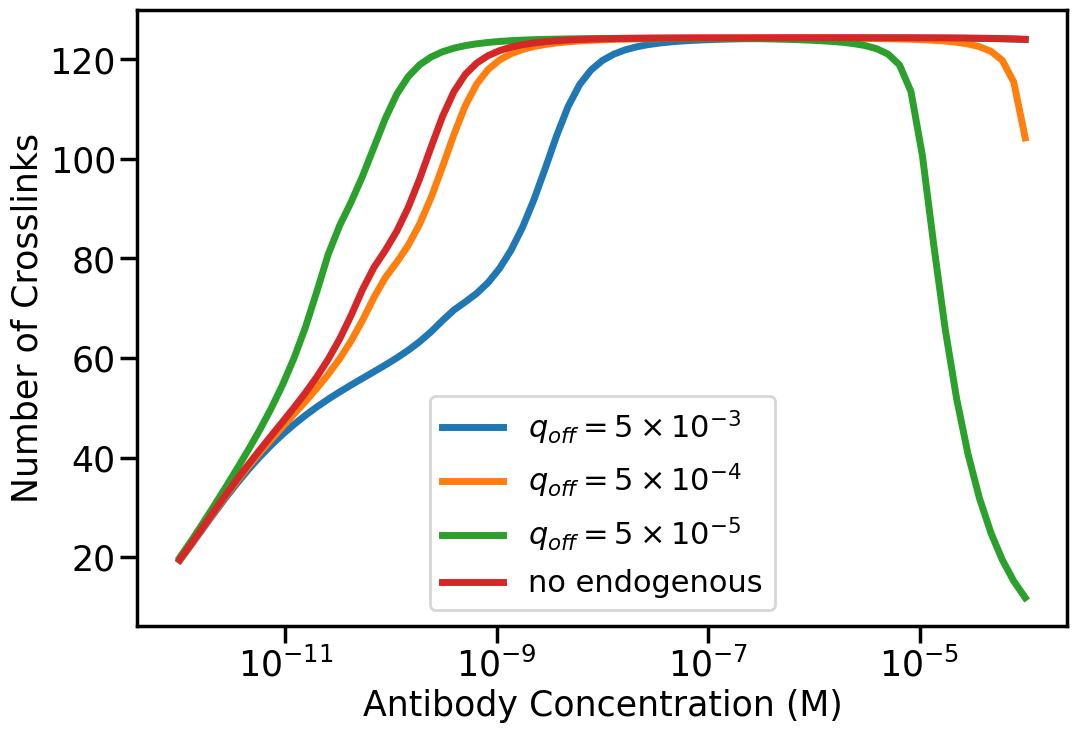

In [290]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(A0s, approx, label=r'$q_{off}=5 \times 10^{-3}$', lw = 5)
ax.semilogx(A0s, approx3, label=r'$q_{off}=5 \times 10^{-4}$', lw = 5)
ax.semilogx(A0s, approx1, label=r'$q_{off}=5 \times 10^{-5}$', lw = 5)
ax.semilogx(A0s, approx2, label=r'no endogenous', lw = 5)
#ax.semilogx(A0s, approx1, label=r'E:T=20', lw = 5)
ax.set_xlabel(r'Antibody Concentration (M)', fontsize=25)
ax.legend(loc='best')
ax.tick_params(labelsize=25)
ax.set_ylabel(r'Number of Crosslinks', fontsize=25)
#ax.set_ylim(0, ftot_synapse)
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/crosslinks_prozone.png', dpi=500)